In [1]:

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
from patchify import patchify
from patchify import unpatchify
from tensorflow.keras.models import load_model

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb

def load_unet_model(patch_size, custom_objects, model_path):
    """
    Load a U-Net model file based on the given patch size.

    Parameters:
    - patch_size (int): The patch size to include in the file name.
    - custom_objects (dict): Custom objects required to load the model (e.g., metrics or loss functions).

    Returns:
    - model: The loaded U-Net model.
    """

    model = load_model(model_path, custom_objects=custom_objects)
    return model



In [4]:
def process_single_image(image, output_size=(1024, 1024)):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box coordinates
    x, y, width, height = cv2.boundingRect(largest_contour)

    # Calculate the side length of the square bounding box
    side_length = max(width, height)

    # Calculate the center of the bounding box
    x_center = x + width // 2
    y_center = y + height // 2

    # Calculate the bounding box
    x_start = max(0, x_center - side_length // 2)
    y_start = max(0, y_center - side_length // 2)
    x_end = min(image.shape[1], x_start + side_length)
    y_end = min(image.shape[0], y_start + side_length)

    # Adjust the starting coordinates if the ending coordinates exceed the image dimensions
    x_start = max(0, x_end - side_length)
    y_start = max(0, y_end - side_length)

    # Crop and resize the image
    cropped_image = image[y_start:y_end, x_start:x_end]
    resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_AREA)

    return resized_image, (x_start, y_start, side_length)


In [5]:
def load_image(image_path):
    """
    Load an image from the specified path and return the image and its shape.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - image: The loaded image in BGR format.
    - shape: The shape of the loaded image (tuple).
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    return image, image.shape

In [6]:



def visualize_processed_image(processed_image, title="Processed Image"):
    """
    Visualize a processed image using Matplotlib.

    Parameters:
    - processed_image: The image to visualize (assumed to be in BGR format).
    - title (str): Title for the plot (default: "Processed Image").
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()




In [7]:



def create_and_reshape_patches(image, patch_size, step):
    """
    Create patches from an image and reshape them for prediction.

    Parameters:
    - image (numpy.ndarray): The input image from which patches will be created.
    - patch_size (int): The size of each patch (assumes square patches).
    - step (int): The step size for patch creation (controls overlap).

    Returns:
    - reshaped_patches (numpy.ndarray): Reshaped patches, normalized to [0, 1].
    - patch_shape (tuple): Shape of the patch grid (rows, cols).
    """
    # Create patches from the image
    image_patches = patchify(image, (patch_size, patch_size, 3), step)

    # Reshape the patches for prediction
    reshaped_patches = image_patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize to [0, 1]

    patch_shape = image_patches.shape[:2]  # Rows and columns of patches
    return reshaped_patches, patch_shape





In [8]:
def predict_patches(model, reshaped_patches, patch_shape, patch_size, batch_size=64):
    """
    Predict patches using the given model and reshape the predictions to match the original patch grid.

    Parameters:
    - model: The trained model to use for predictions.
    - reshaped_patches (numpy.ndarray): Reshaped patches ready for prediction.
    - patch_shape (tuple): Shape of the patch grid (rows, cols).
    - patch_size (int): The size of each patch (assumes square patches).
    - batch_size (int): Batch size for predictions (default: 64).

    Returns:
    - predicted_patches (numpy.ndarray): Predicted patches reshaped to the patch grid structure.
    """
    # Predict the patches
    predictions = model.predict(reshaped_patches, batch_size=batch_size, verbose=1)

    # Reshape the predictions to match the patch grid structure
    predicted_patches = predictions.reshape(
        patch_shape[0], patch_shape[1], patch_size, patch_size, 1
    )

    return predicted_patches



In [9]:



def reconstruct_full_mask(predicted_patches, image_shape):
    """
    Reconstruct the full predicted mask from predicted patches.

    Parameters:
    - predicted_patches (numpy.ndarray): Predicted patches with shape (rows, cols, patch_size, patch_size).
    - image_shape (tuple): Original image shape (height, width).

    Returns:
    - predicted_mask_padded (numpy.ndarray): The reconstructed full mask.
    """
    # Remove the extra channel dimension
    predicted_patches = predicted_patches.squeeze(-1)  # Remove the last dimension if it exists

    # Reconstruct the full predicted mask
    predicted_mask_padded = unpatchify(predicted_patches, image_shape)

    return predicted_mask_padded




In [10]:



def reverse_cropping(mask, coords, original_shape):
    x_start, y_start, side_length = coords
    x_end, y_end = x_start + side_length, y_start + side_length

    # Create a blank mask of the original image size
    aligned_mask = np.zeros(original_shape[:2], dtype=mask.dtype)

    # Resize the mask to fit the original cropped area
    resized_mask = cv2.resize(mask, (side_length, side_length), interpolation=cv2.INTER_NEAREST)

    # Place the resized mask back into the corresponding coordinates
    aligned_mask[y_start:y_end, x_start:x_end] = resized_mask

    aligned_mask = (aligned_mask > 0.5).astype(np.uint8) * 255

    print(f"{np.unique(aligned_mask)}")
    print(f"Aligned mask: {aligned_mask.shape}")
    return aligned_mask




In [11]:



def visualize_mask_overlay(image, binary_mask, alpha=0.5):
    """
    Create and visualize a colored overlay of the binary mask on the original image.

    Parameters:
    - image (numpy.ndarray): The original image (assumed to be in BGR format).
    - binary_mask (numpy.ndarray): The binary mask (assumed to be 2D).
    - alpha (float): Blending factor for the mask overlay (default: 0.5).

    Returns:
    - overlayed_image (numpy.ndarray): The image with the binary mask overlay applied.
    """
    # Create a colored mask (green channel only)
    color_of_mask = np.zeros_like(image)
    color_of_mask[:, :, 1] = binary_mask

    # Blend the mask with the original image
    overlayed_image = cv2.addWeighted(color_of_mask, alpha, image, 1 - alpha, 0)

    # Visualize the results
    f, ax = plt.subplots(1, 3, dpi=150, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(binary_mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Predicted Binary Mask')

    ax[2].imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
    ax[2].axis('off')
    ax[2].set_title('Overlay')
    plt.tight_layout()
    plt.show()

    return overlayed_image




In [12]:



def main(image_folder, output_folder, model_path, patch_size, batch_size=64):
    """
    Main function to process images, generate binary masks, and save them.

    Parameters:
    - image_folder (str or Path): Path to the folder containing input images.
    - output_folder (str or Path): Path to save the binary masks.
    - model_path (str or Path): Path to the trained U-Net model file.
    - patch_size (int): Patch size for splitting and predicting.
    - batch_size (int): Batch size for model predictions (default: 64).
    """
    # Ensure paths are Path objects
    image_folder = Path(image_folder)
    output_folder = Path(output_folder)

    # Create the output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Load the U-Net model
    model = load_unet_model(patch_size, {"f1": f1}, model_path=model_path)

    # Process each image in the folder
    for image_path in image_folder.iterdir():
        if not image_path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
            continue

        # Load and preprocess the image
        image, image_shape = load_image(str(image_path))
        print(image_path, image.shape)
        preprocessed_image, crop_coords = process_single_image(image, output_size=(1024, 1024))

        # Create and reshape patches
        reshaped_patches, patch_shape = create_and_reshape_patches(preprocessed_image, patch_size, patch_size)

        # Predict the patches
        predicted_patches = predict_patches(model, reshaped_patches, patch_shape, patch_size, batch_size)

        # Reconstruct the full mask
        predicted_mask_padded = reconstruct_full_mask(predicted_patches, preprocessed_image.shape[:2])

        # Reverse cropping to align with the original image size
        binary_mask = reverse_cropping(predicted_mask_padded, crop_coords, image.shape)

        # Save the binary mask
        mask_save_path = output_folder / f"{image_path.stem}_mask.png"
        cv2.imwrite(str(mask_save_path), binary_mask)

        # Optionally visualize the results
        visualize_mask_overlay(image, binary_mask)

        print(f"Processed and saved mask for: {image_path.name}")




kaggle_images\test_image_1.png (3006, 4112, 3)
1/1 [==============================] - 6s 6s/step
[  0 255]
Aligned mask: (3006, 4112)


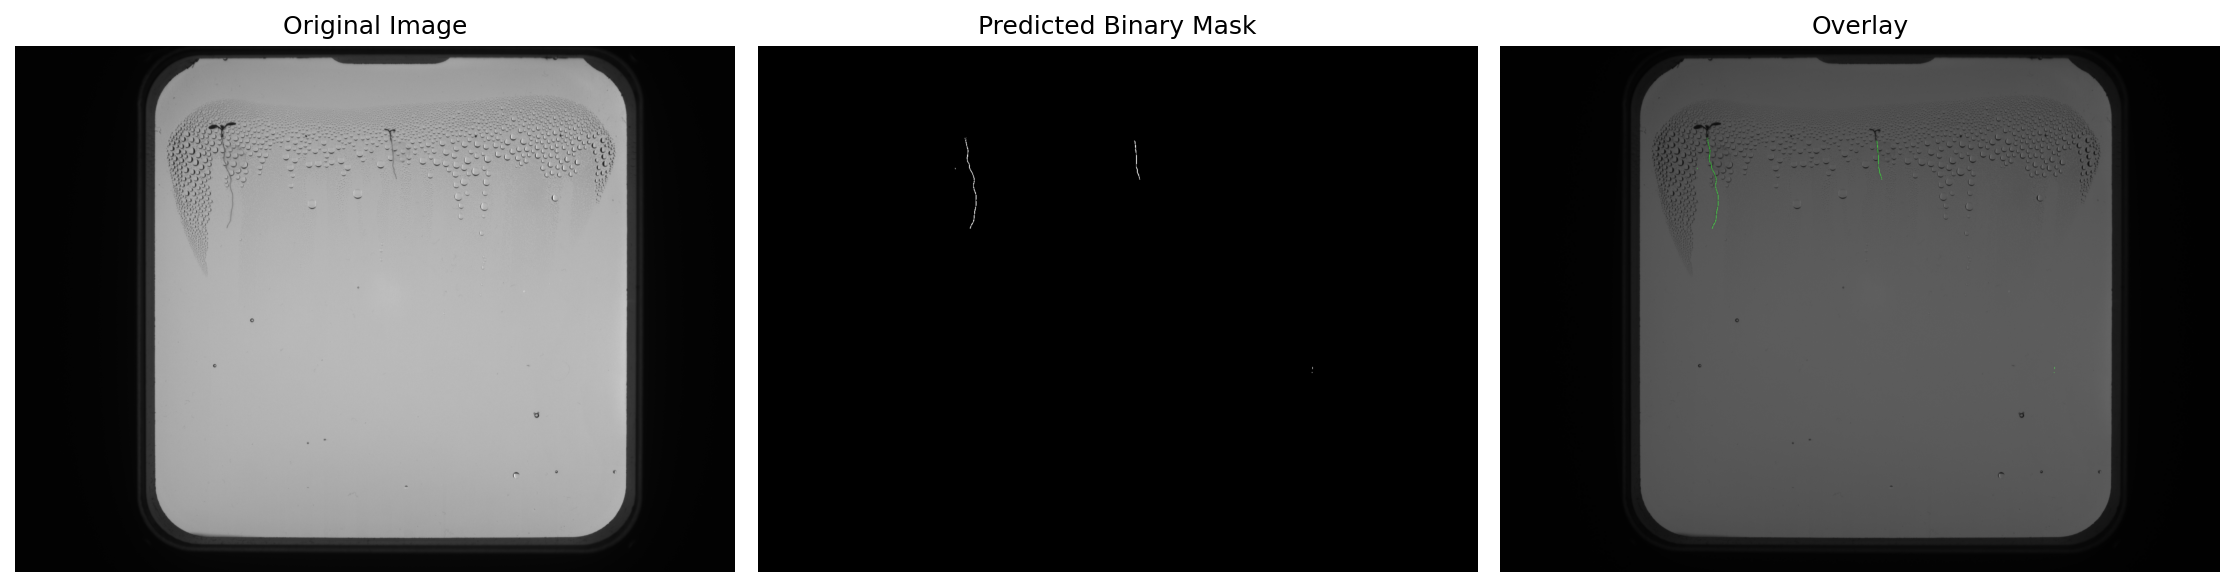

Processed and saved mask for: test_image_1.png
kaggle_images\test_image_10.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


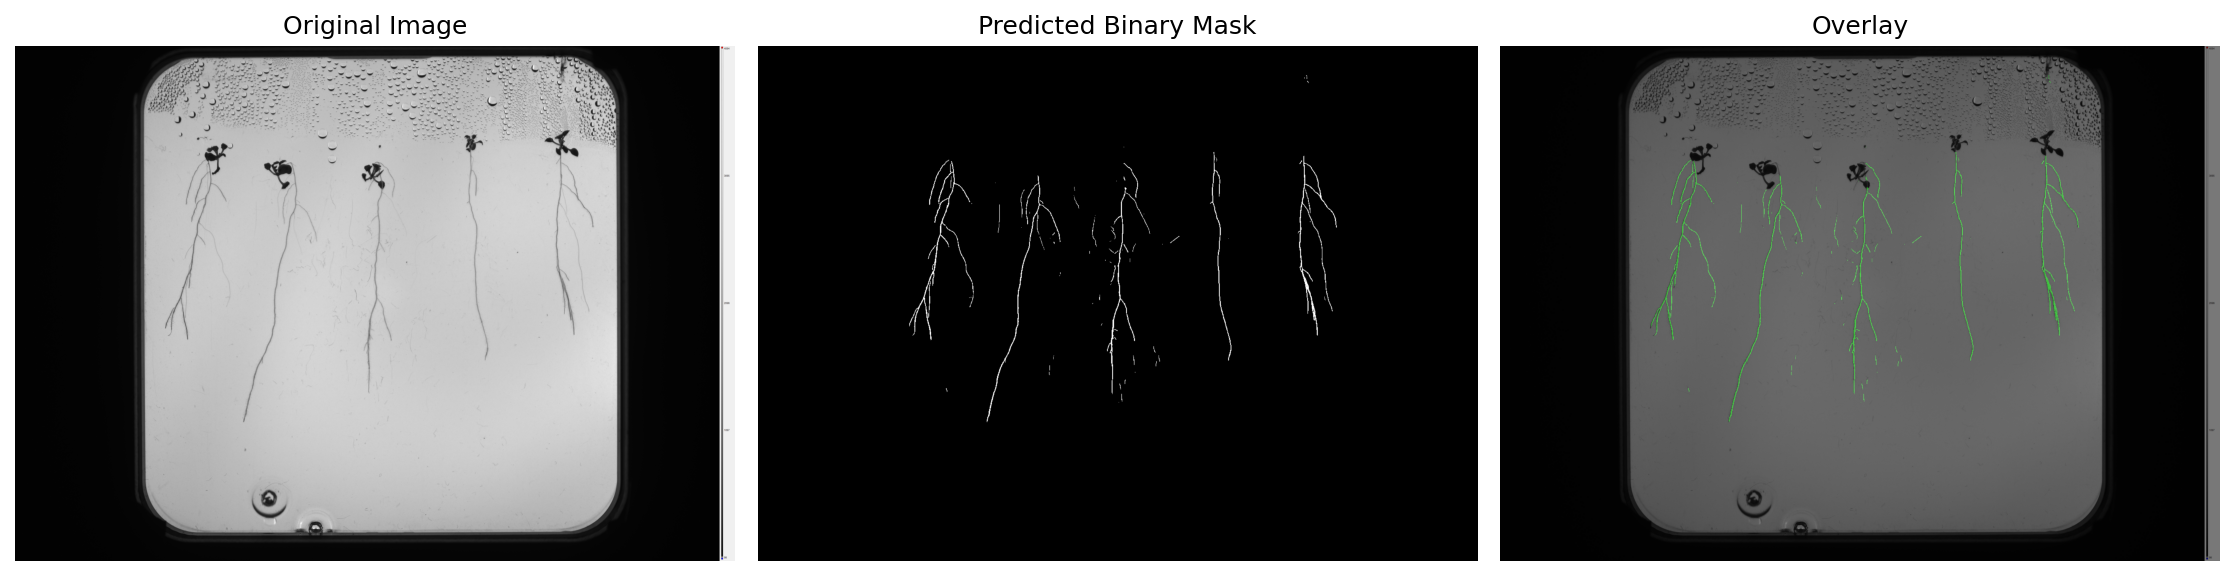

Processed and saved mask for: test_image_10.png
kaggle_images\test_image_11.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


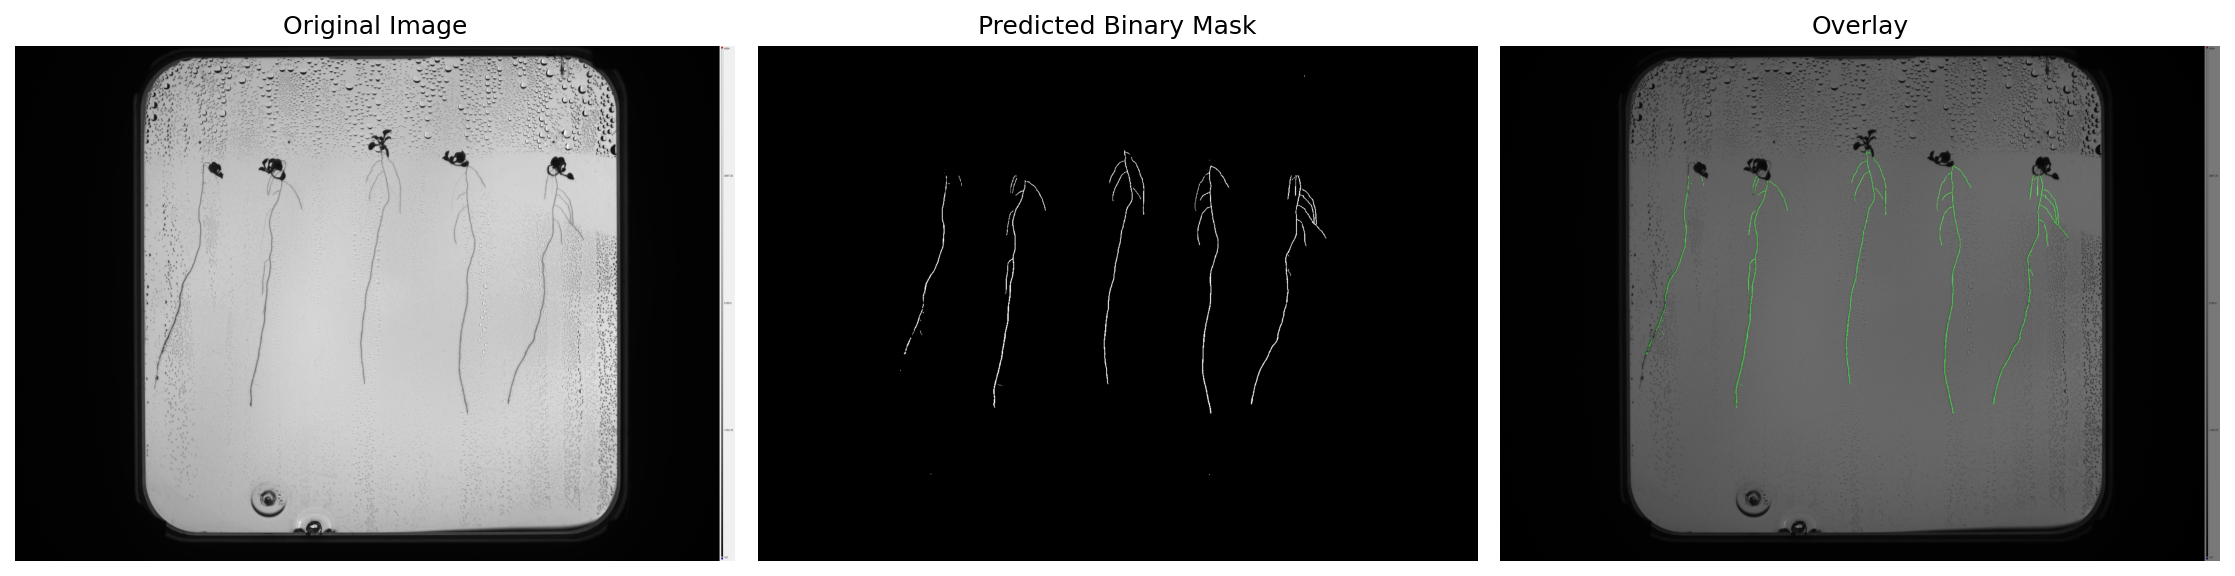

Processed and saved mask for: test_image_11.png
kaggle_images\test_image_12.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


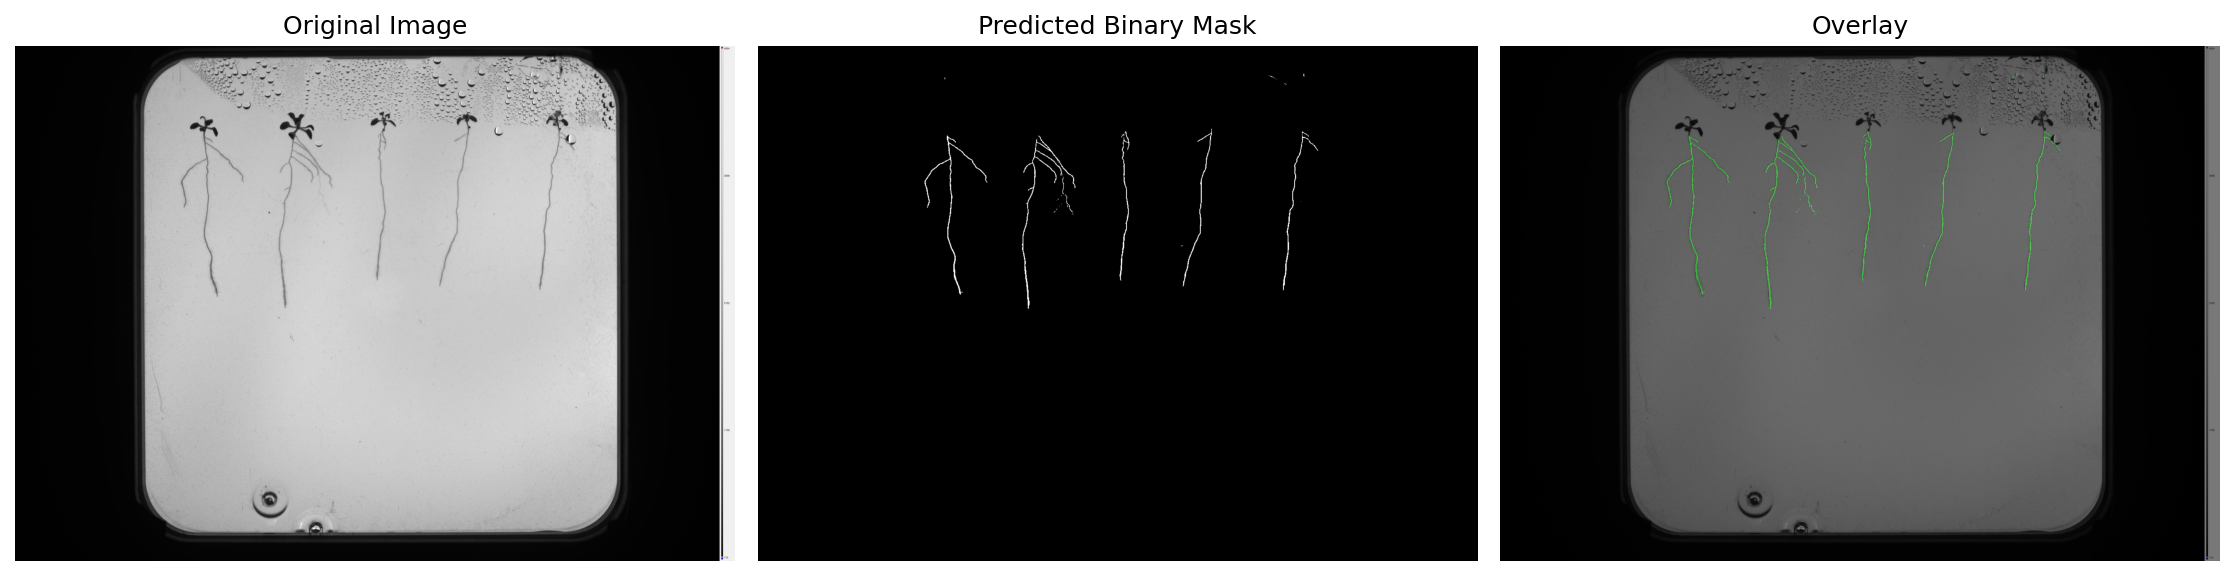

Processed and saved mask for: test_image_12.png
kaggle_images\test_image_13.png (2999, 4202, 3)
1/1 [==============================] - 6s 6s/step
[  0 255]
Aligned mask: (2999, 4202)


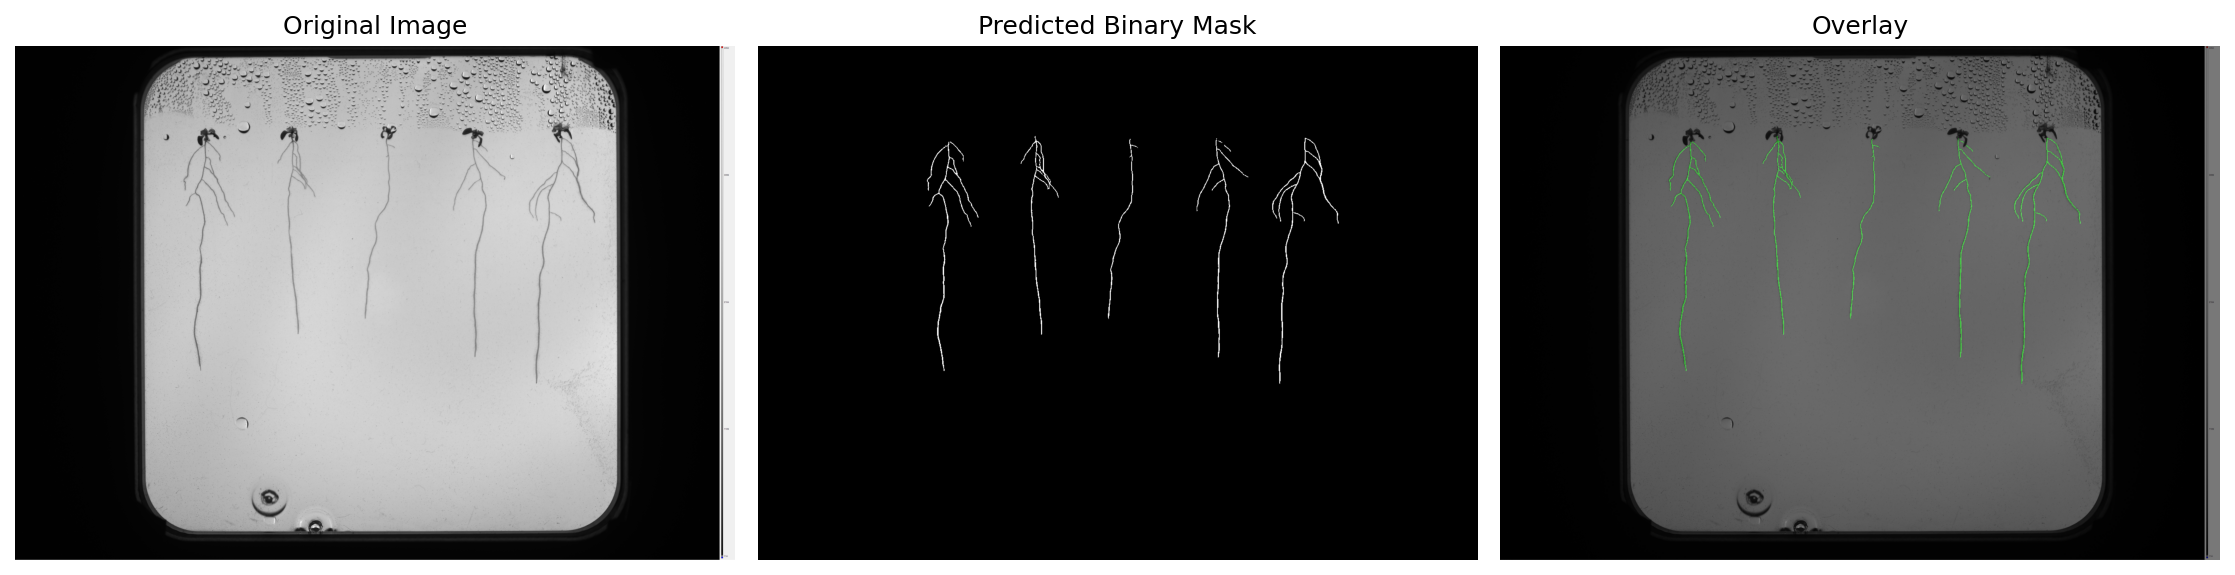

Processed and saved mask for: test_image_13.png
kaggle_images\test_image_14.png (3006, 4202, 3)
1/1 [==============================] - 6s 6s/step
[  0 255]
Aligned mask: (3006, 4202)


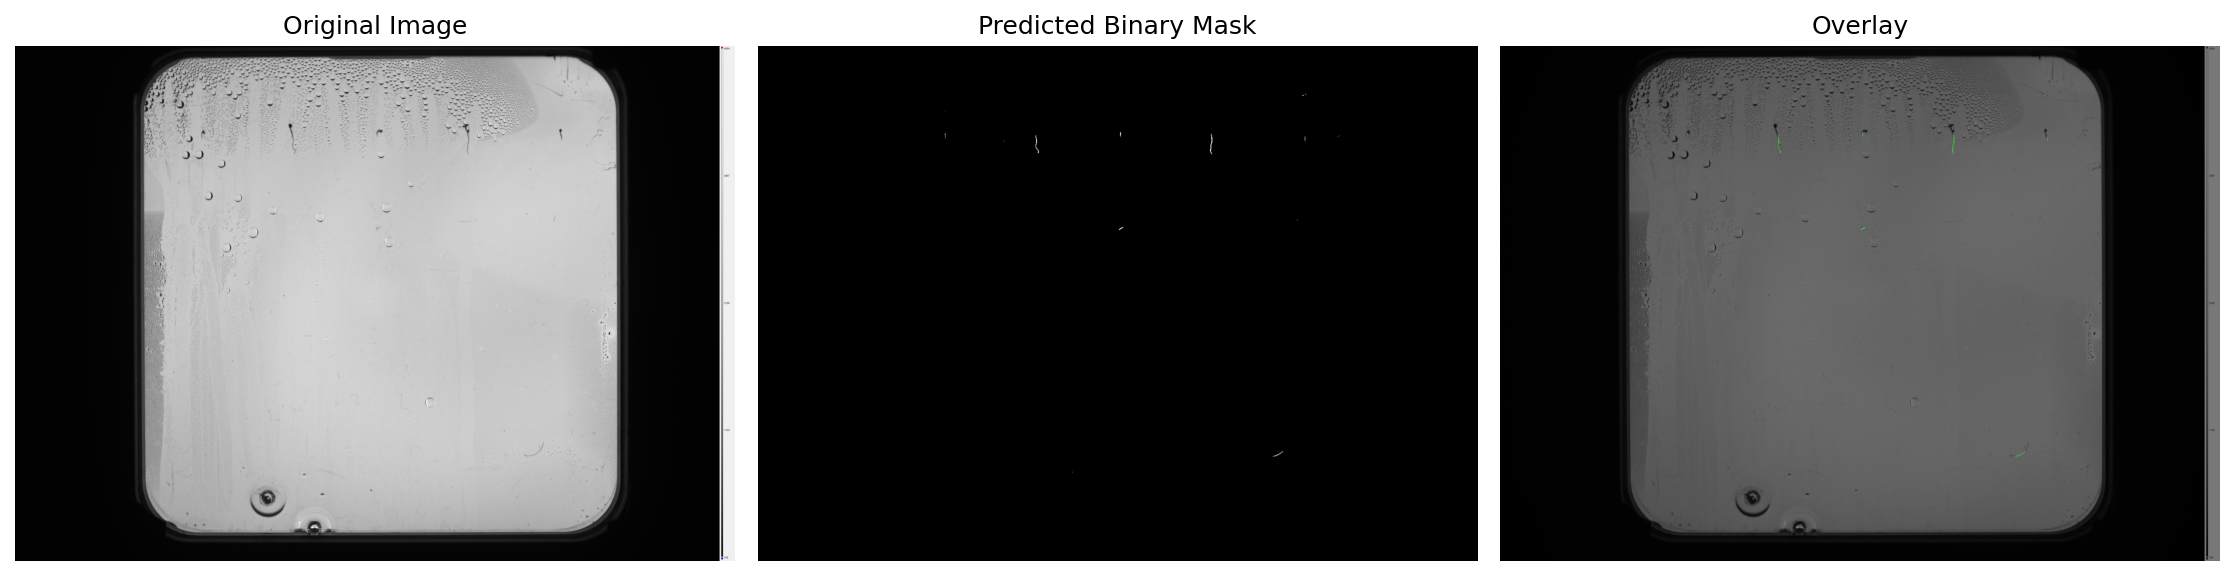

Processed and saved mask for: test_image_14.png
kaggle_images\test_image_15.png (3006, 4202, 3)
1/1 [==============================] - 10s 10s/step
[  0 255]
Aligned mask: (3006, 4202)


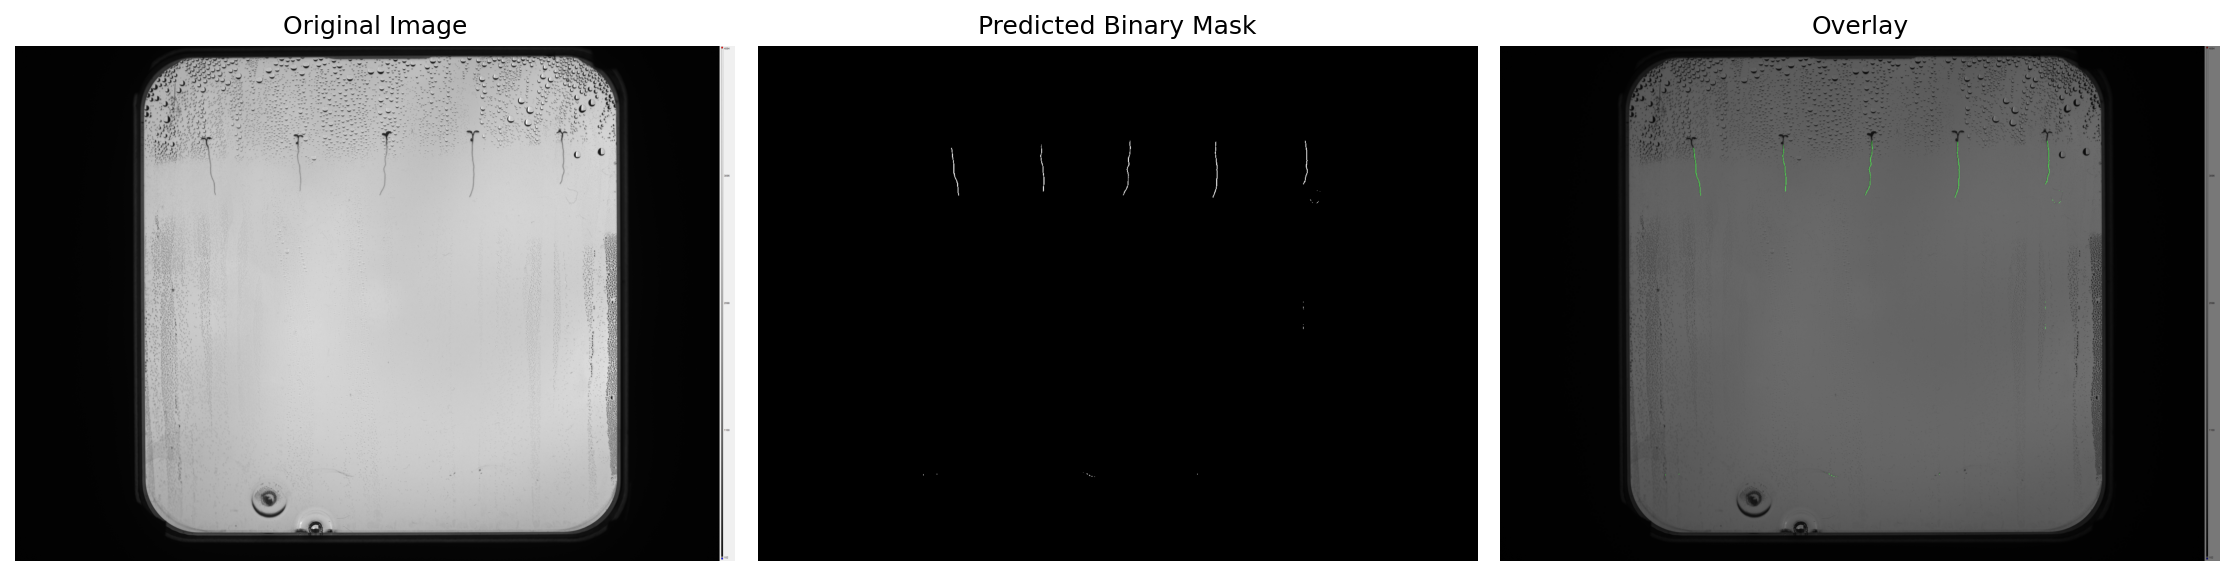

Processed and saved mask for: test_image_15.png
kaggle_images\test_image_16.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


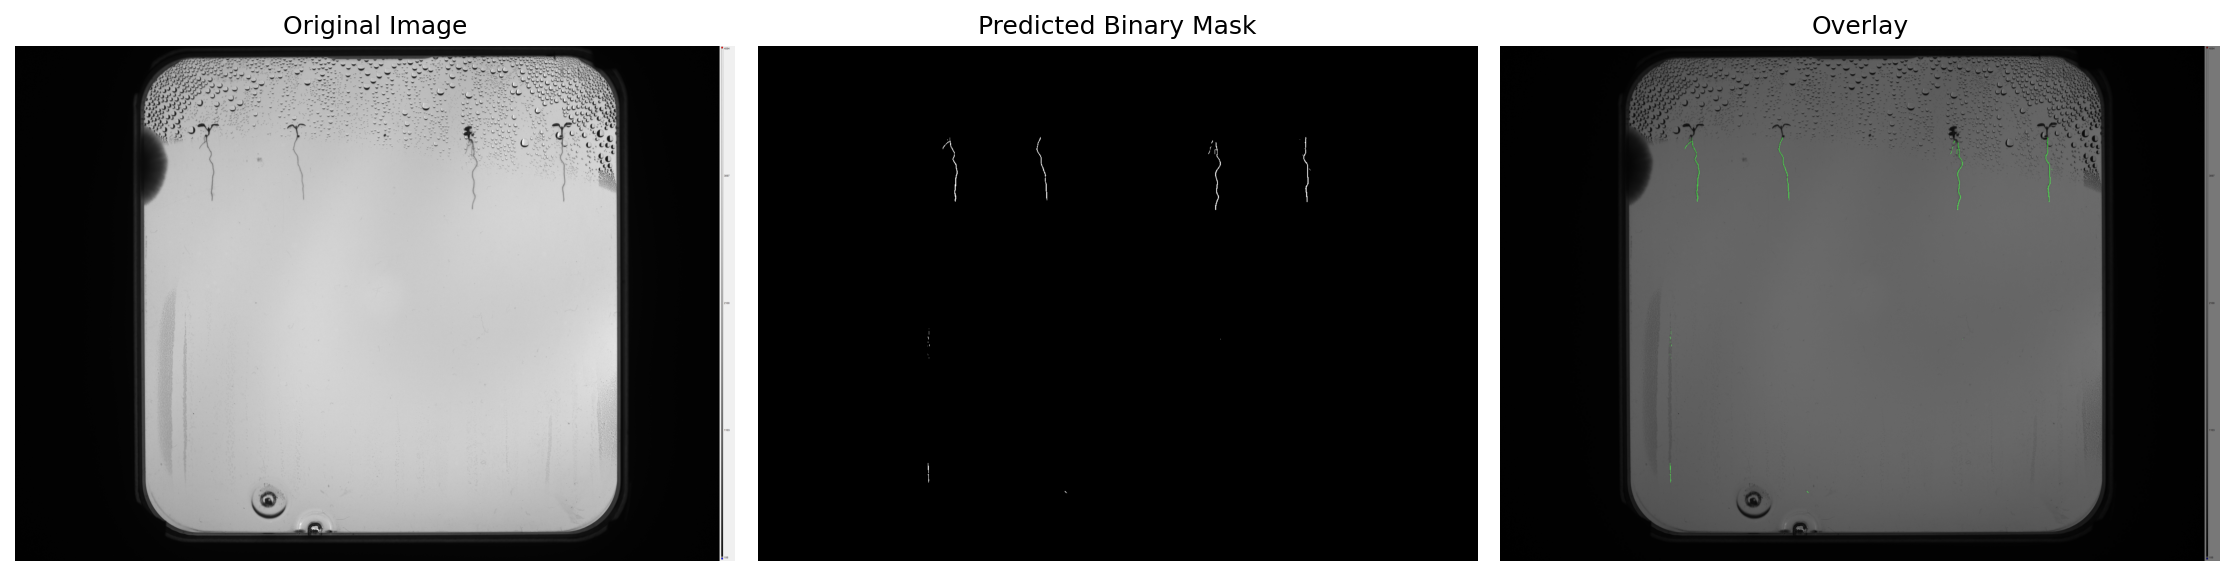

Processed and saved mask for: test_image_16.png
kaggle_images\test_image_17.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


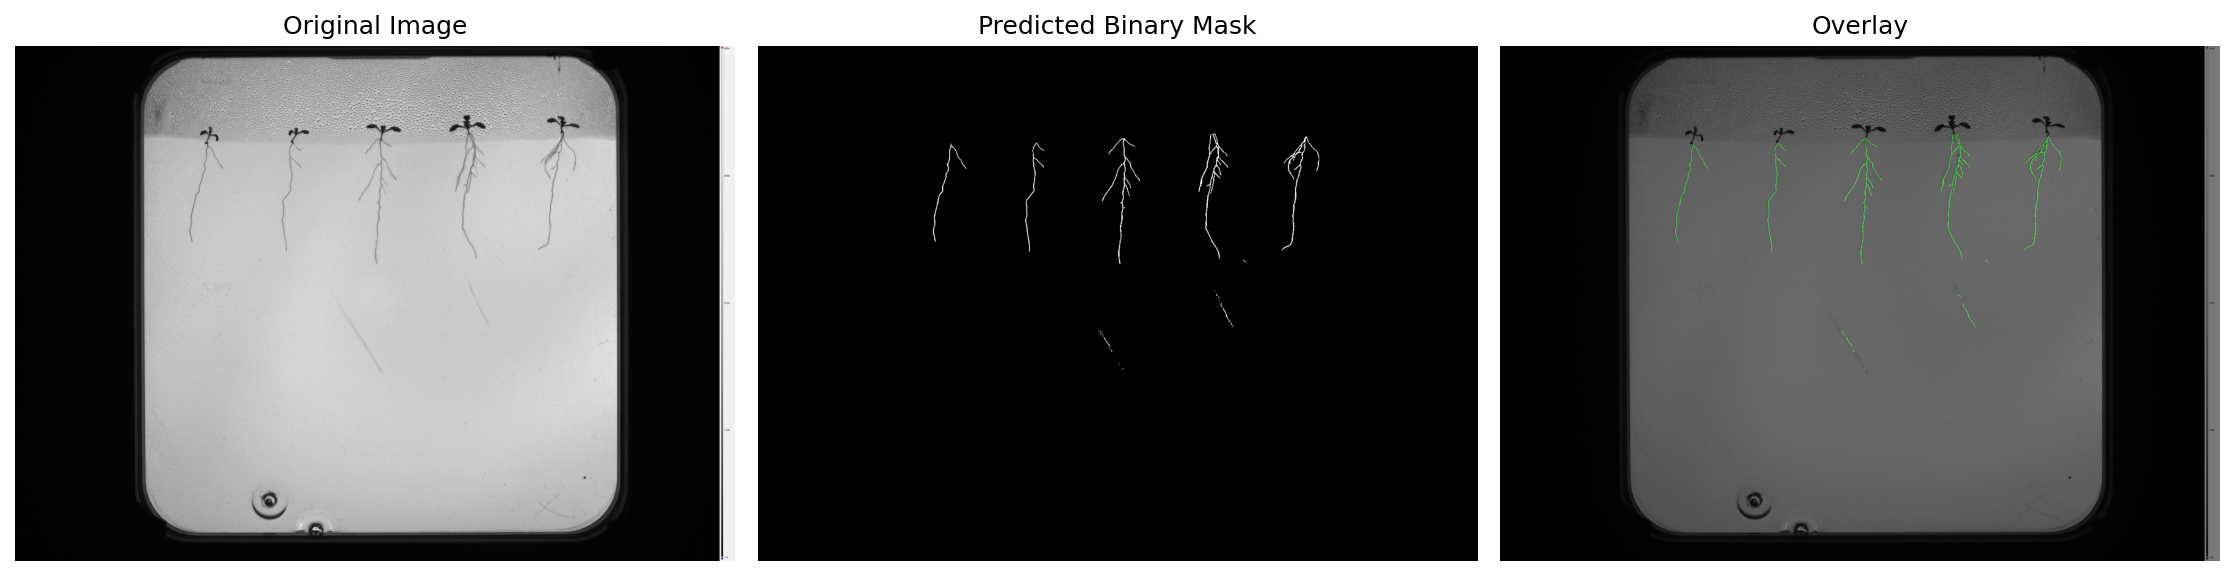

Processed and saved mask for: test_image_17.png
kaggle_images\test_image_18.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


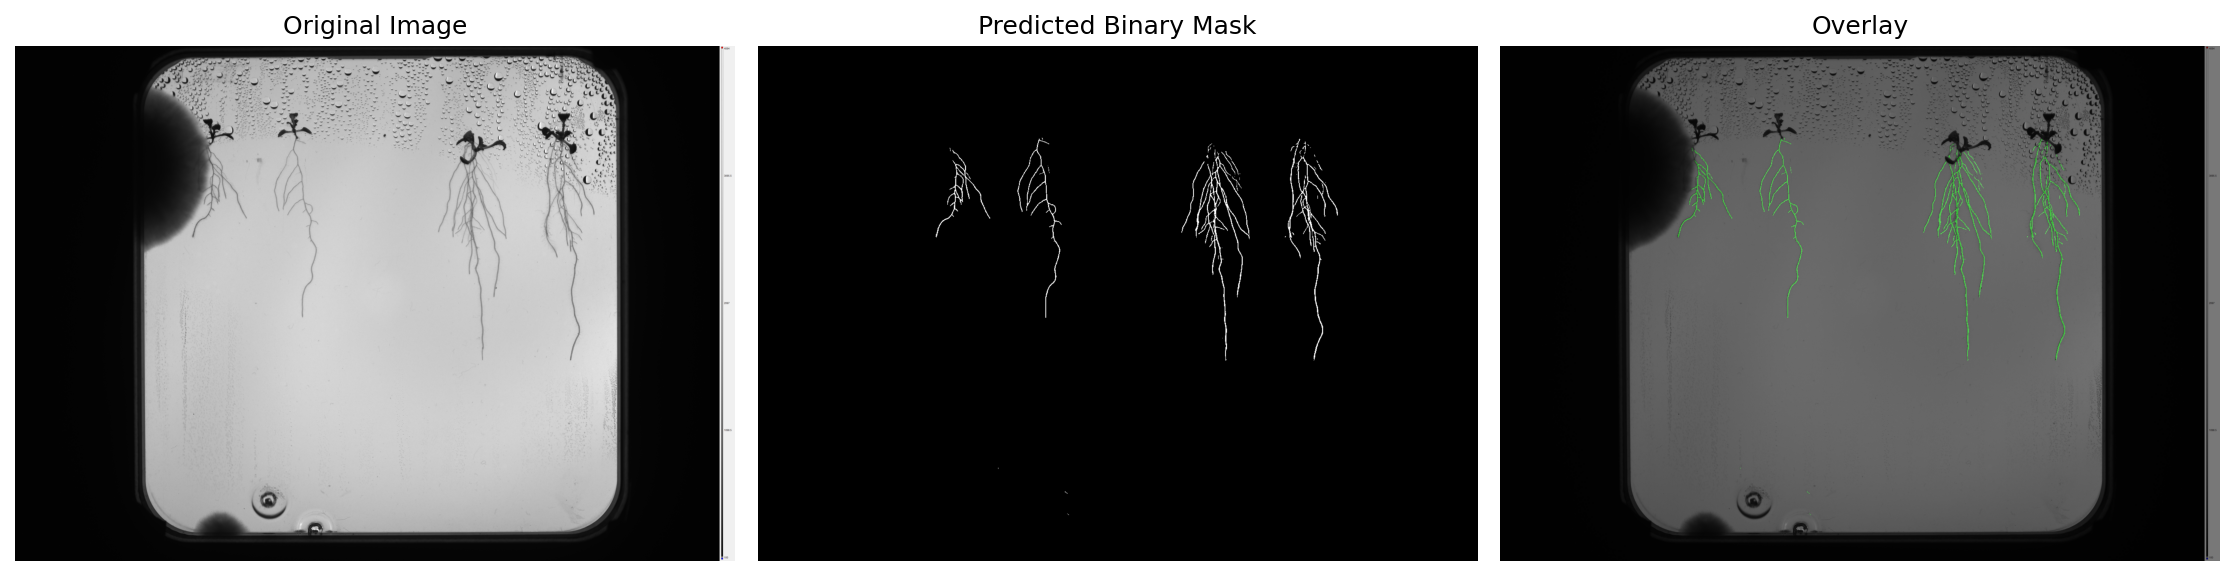

Processed and saved mask for: test_image_18.png
kaggle_images\test_image_2.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


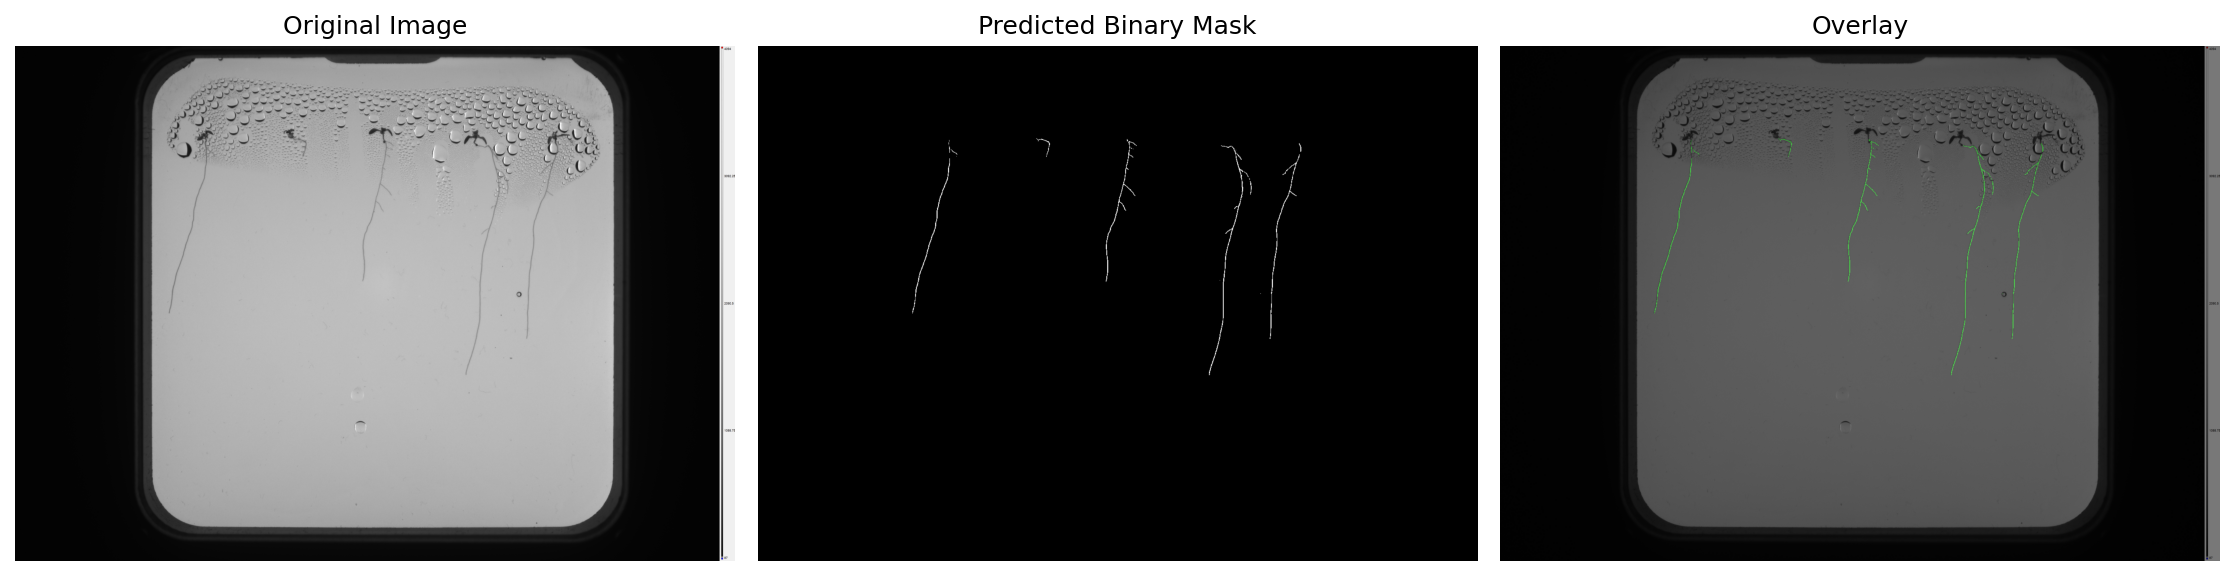

Processed and saved mask for: test_image_2.png
kaggle_images\test_image_3.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


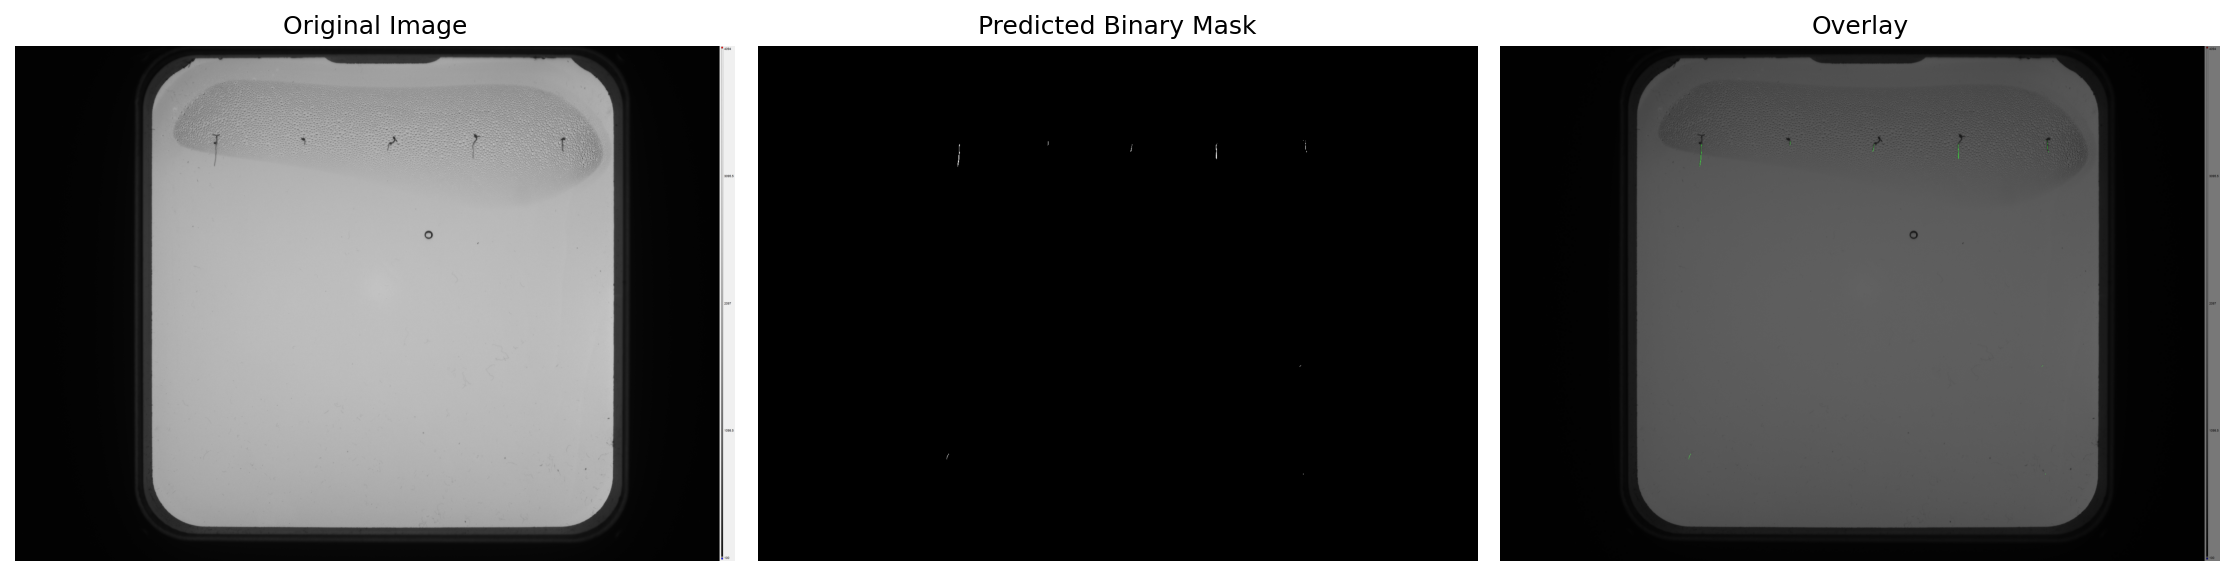

Processed and saved mask for: test_image_3.png
kaggle_images\test_image_4.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


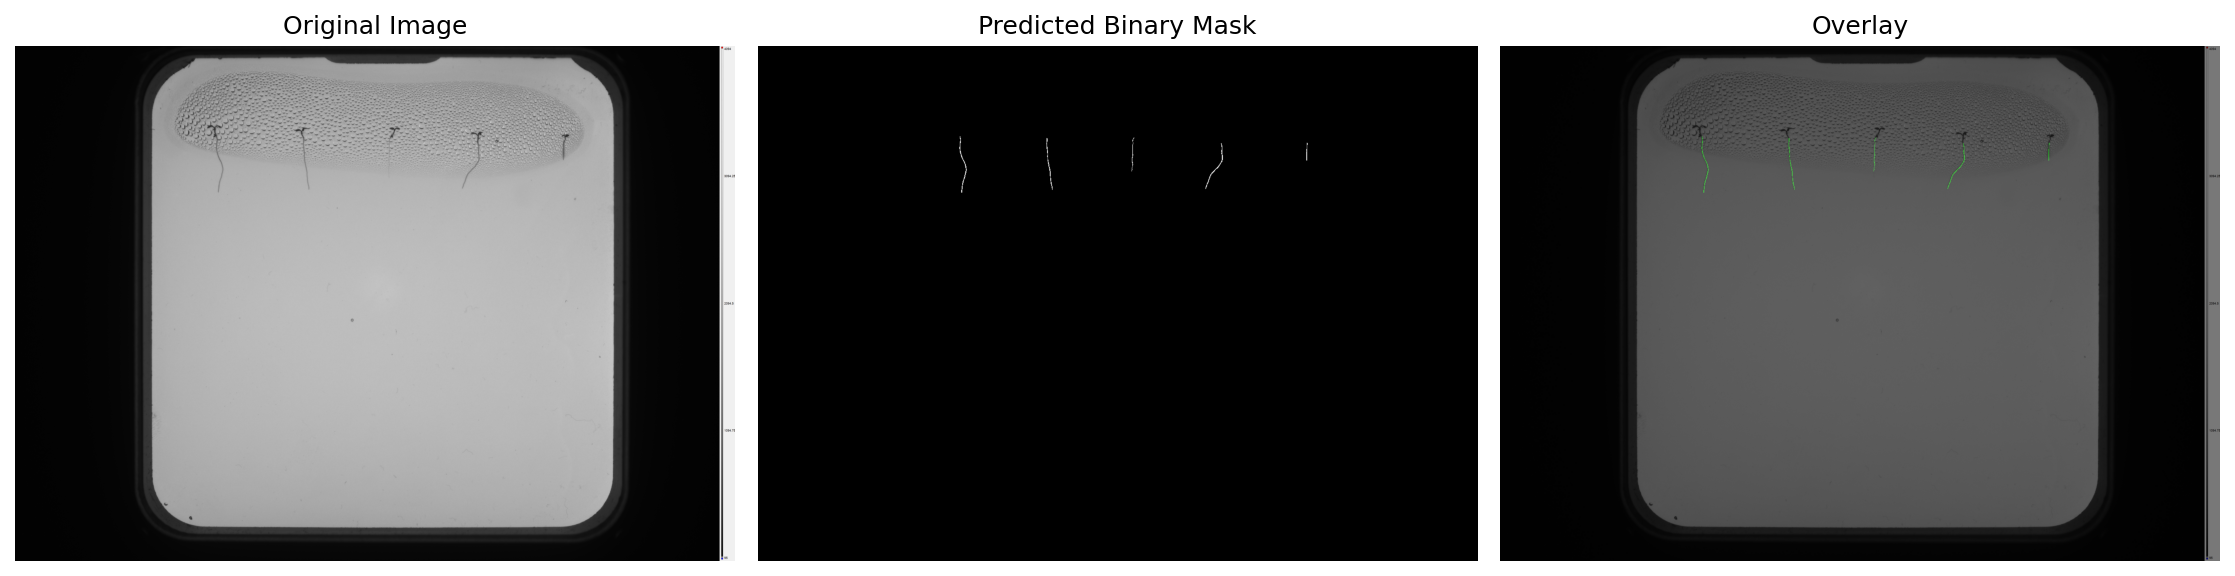

Processed and saved mask for: test_image_4.png
kaggle_images\test_image_5.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


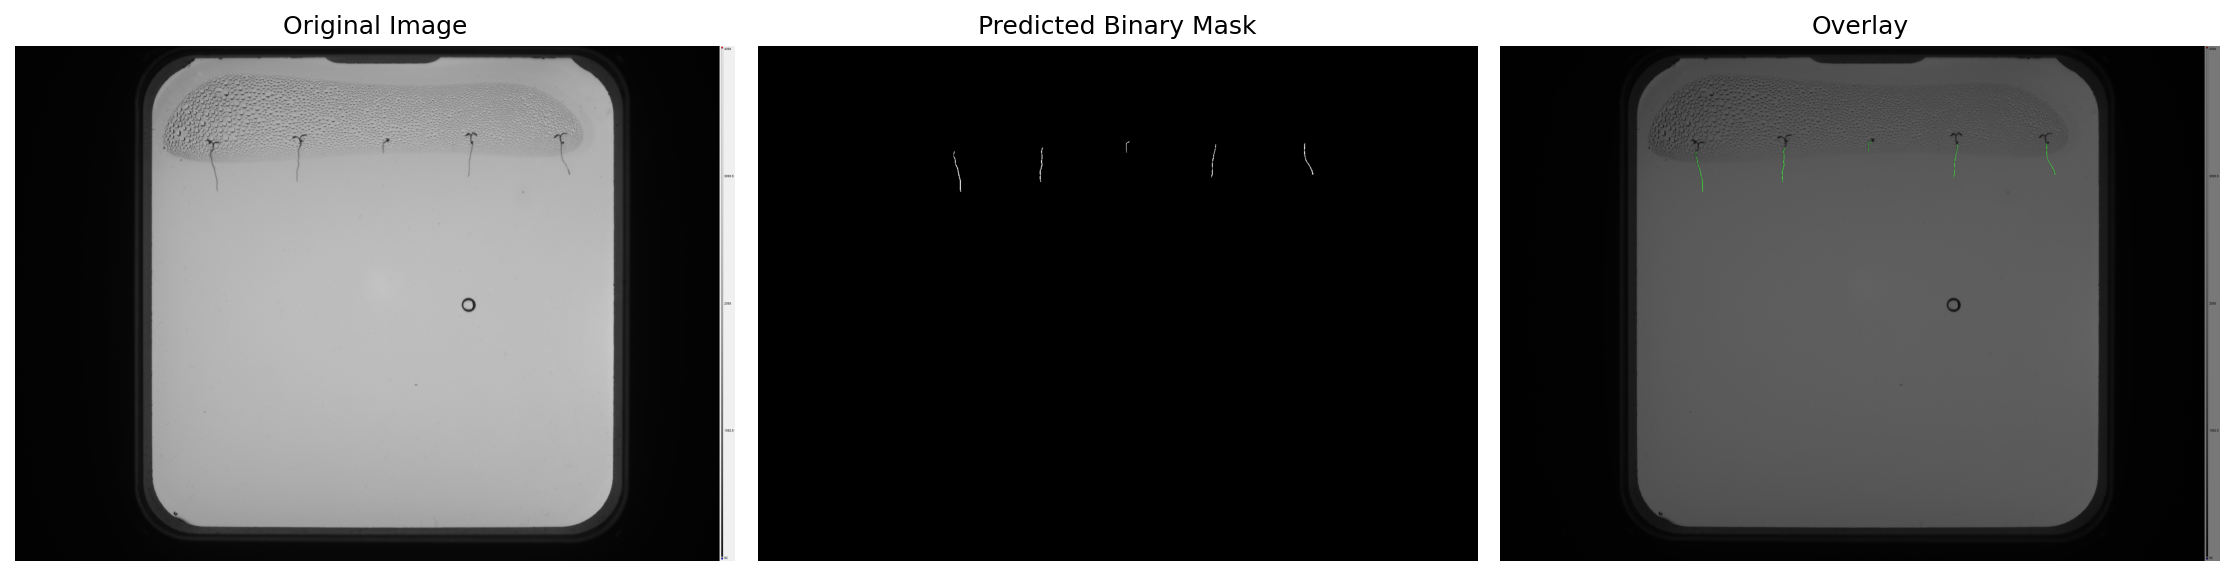

Processed and saved mask for: test_image_5.png
kaggle_images\test_image_6.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


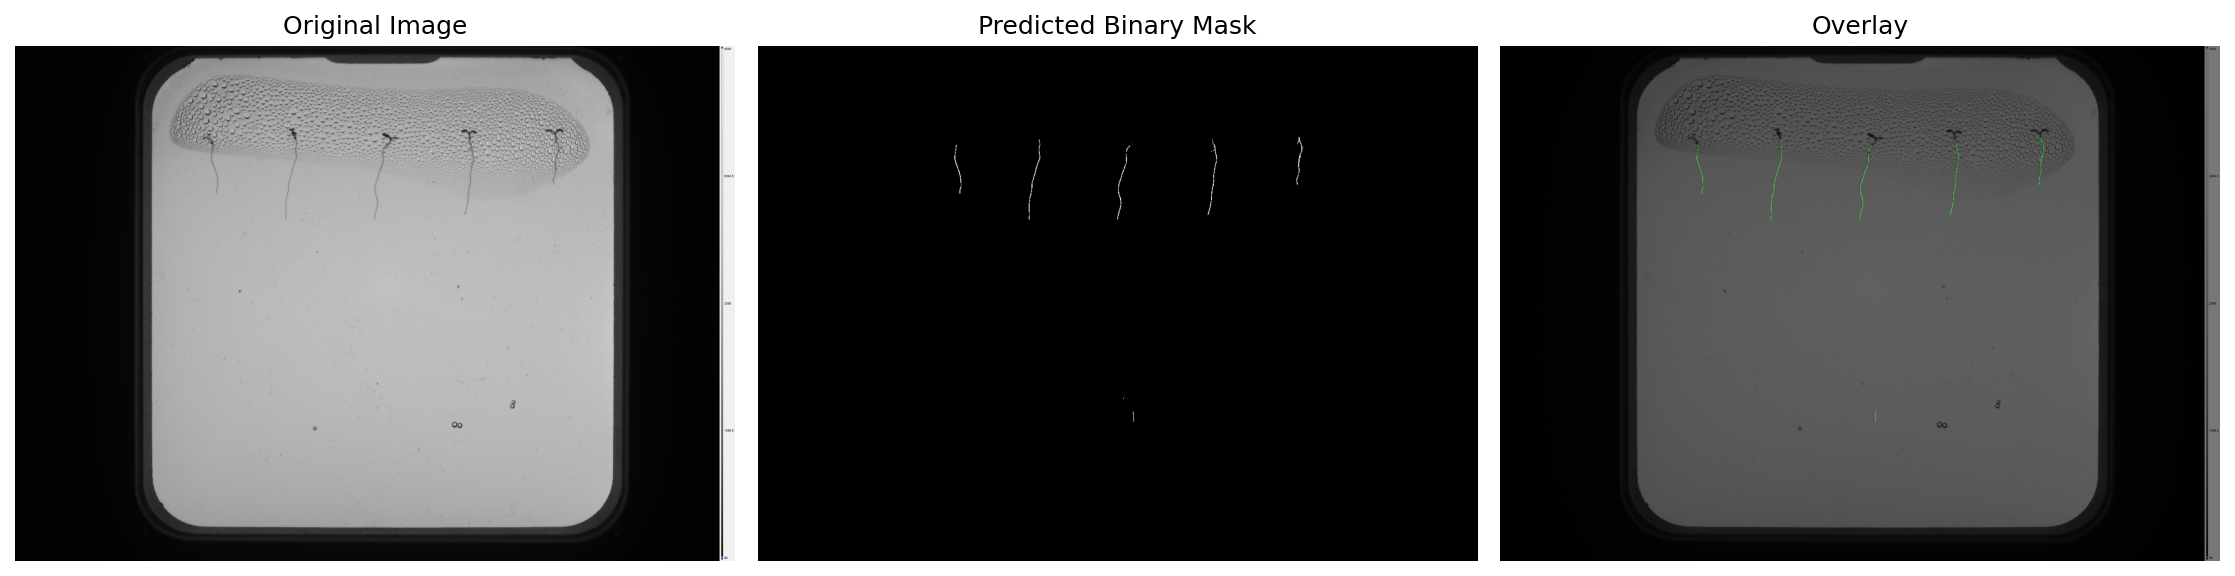

Processed and saved mask for: test_image_6.png
kaggle_images\test_image_7.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


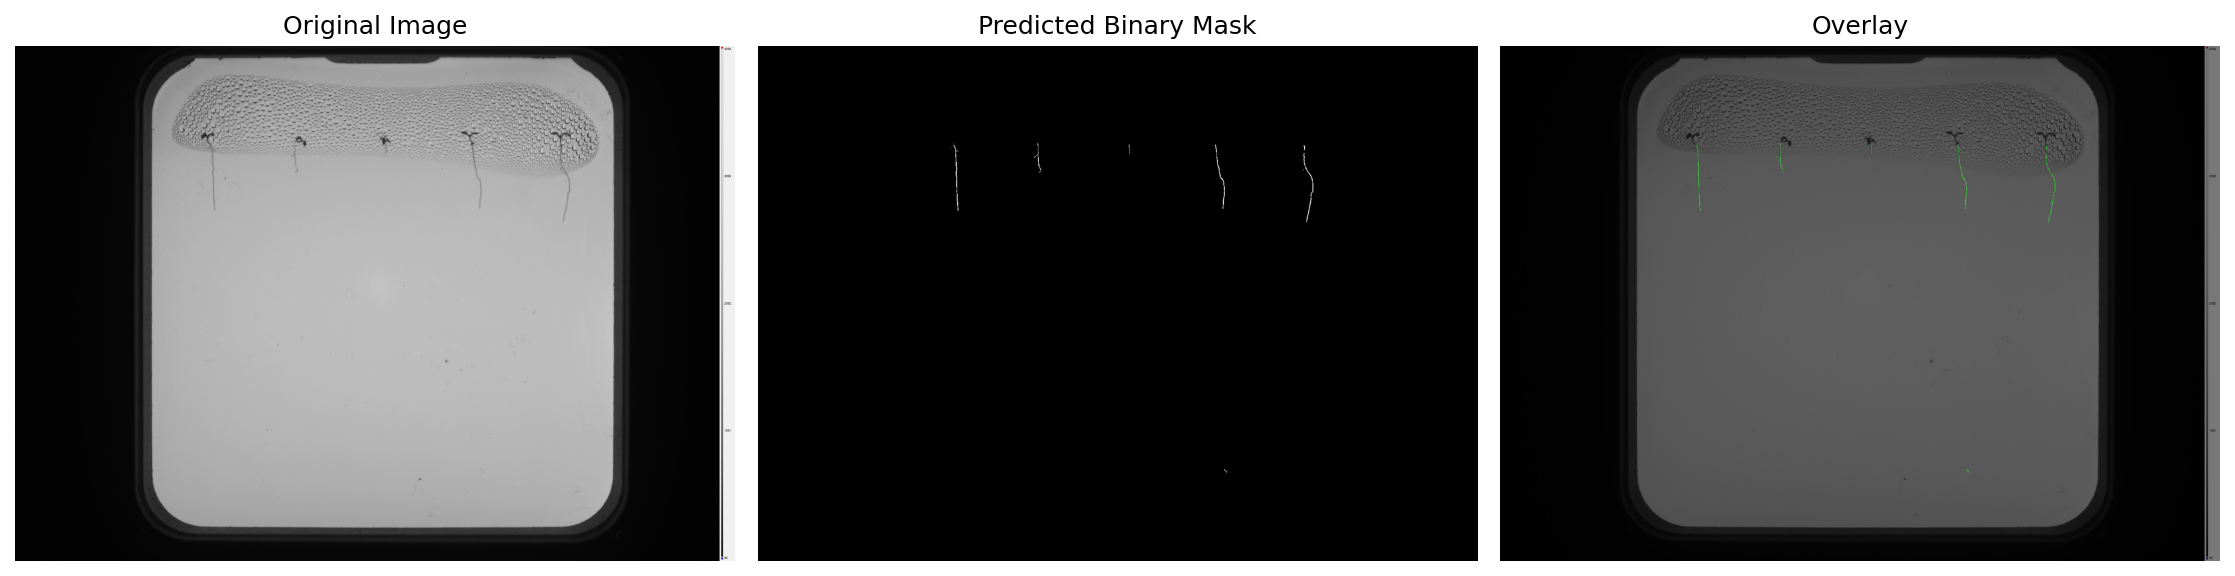

Processed and saved mask for: test_image_7.png
kaggle_images\test_image_8.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


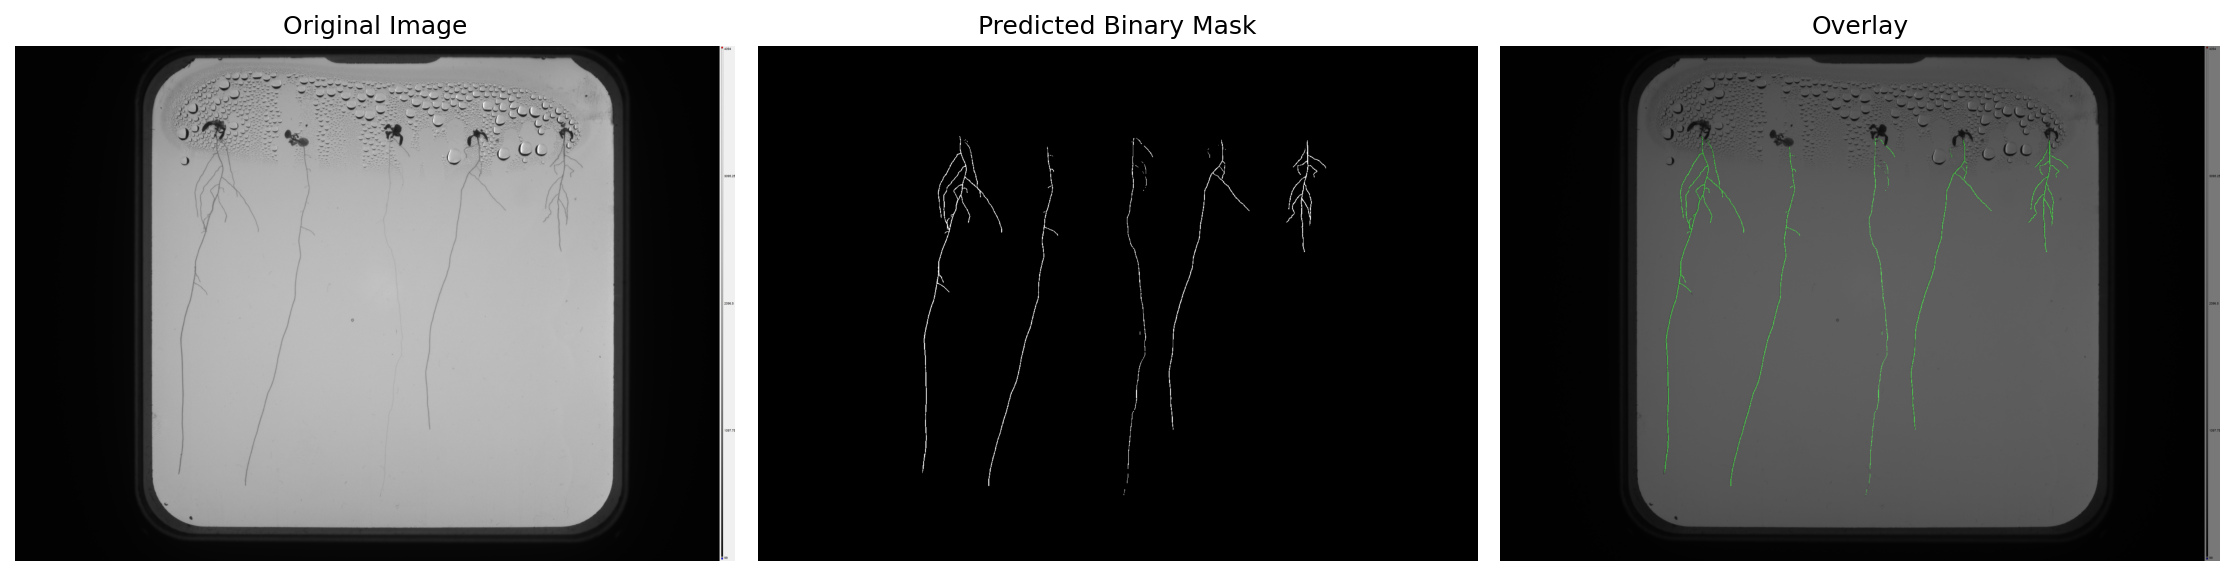

Processed and saved mask for: test_image_8.png
kaggle_images\test_image_9.png (3006, 4202, 3)
1/1 [==============================] - 5s 5s/step
[  0 255]
Aligned mask: (3006, 4202)


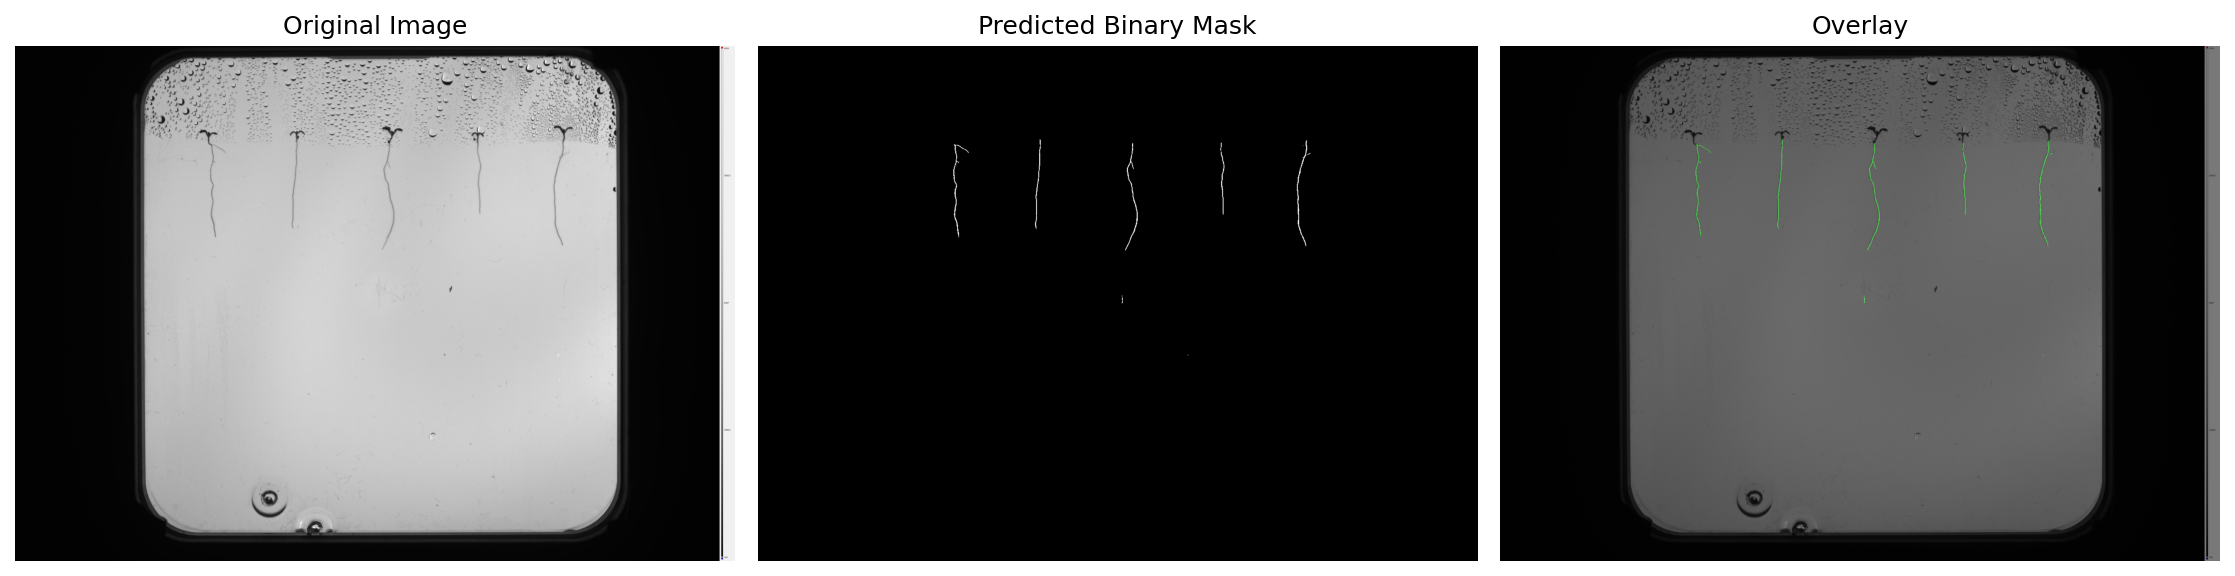

Processed and saved mask for: test_image_9.png


In [ ]:


IMAGE_FOLDER = Path("./kaggle_images")  # Path to the folder with input images
OUTPUT_FOLDER = Path("./predictions")  # Path to save predictions
MODEL_PATH = Path("unet_model_128px.h5")  # Model file path
PATCH_SIZE = 128  # Patch size

main(IMAGE_FOLDER, OUTPUT_FOLDER, MODEL_PATH, PATCH_SIZE, batch_size=64)
